# Processing and analysis of data of raw fltrace traces

## 0. Prerequisites
1. The traces obtained using `fltrace record -M <M_value> -L <L_value> -- program_name`. The parent folder of the traces is designed in the `PARENT_FOLDER_PATH` constant. Inside the parent folder should be several children folders named after benchmark/program traced. Inside each children folder should be grandchildren folders, one per each `(M,L)` pair. Then, inside each grandchildren folder should be the output files of fltrace, that is `fltrace-data-faults*.out`, `fltrace-data-procmaps*.out`, and (optionally) `fltrace-data-stats*.out`. 

    One example hierarchy is 

    ```
    parent/                                   
    ├── canneal/                              
    ┆   ├──200_50/                            
    ┆   ┆   ├──fltrace-data-faults-56090-1.out
    ┆   ┆   ├──fltrace-data-procmaps-56090.out
    ┆   ┆   └──fltrace-data-stats-56090.out   
    ┆   ├──200_100/                           
    ┆   ┆   ├──fltrace-data-faults-55308-1.out
    ┆   ┆   ├──fltrace-data-procmaps-55308.out
    ┆   ┆   └──fltrace-data-stats-55308.out   
    ┆   ├──200_150/                           
    ┆   ┆   ├──...                            
    ┆   └──200_200/                           
    ┆       ├──...                            
    └── fludanimate/                          
        ├──...                                
    ```
    See [the fltrace guide](../data/fltrace.md) to get information about how to get `fltrace` running, as well as how to extend/fix it to get more data. 

2. The objectdumps (`objdump -d /path/to/lib_or_executable_name > lib_or_executable_name`) of all relevant librairies accessed by the traced programs. The folder containing all the objdumps is designed in the `OBJDUMP_FOLDER_PATH` constant. That is, if a library/executable is present in one of the `procmaps` of one of the trace runs, its objdump should be in this directory.

    One example hierarchy is 

    ```
    objdumps/               
    ├── canneal             
    ├── fludanimate         
    ├── fltrace.so          
    ├── ld-linux-x86-64.so.2
    ├── libc.so.6           
    ├── libgcc_s.so.1       
    ├── libm.so.6           
    └── libstdc++.so.6.0.30 
    ```


### Constants & imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import swifter # used even though marked as unused, do not delete 
from utils.fltrace_classes import *
from utils.constants import *
from utils.prepro import *
from plotters import plotter
import matplotlib.pyplot as plt
import functools as ft
import math
from itertools import chain

In [3]:
PARENT_FOLDER_PATH = "../data/parsec_raw_out/"
OBJDUMP_FOLDER_PATH = "../data/objdumps/"

# I. Pre-processing of the trace(s)

First, let us confirm that we have the correct directory tree, as defined in the prerequisites. Let's start by checking that the `objdump` looks correct. Note that we can't do extensive check before reading through the procmaps, which we will do at a later stage.

In [4]:
check_correct_dir(OBJDUMP_FOLDER_PATH)

Then, let's look at the traces data. We take the opportunity of traversing the tree of path to load the relevant data, depending on the value of the `LOAD_DATA` flag.

In [5]:
# choose between "all" to load everything, "" to load nothing, <benchmark_name> to load all runs of one particular benchmark, and parent-relative <path_to/grandchild_directory> if you want to load only one specific run
# for example, LOAD_DATA can therefore be "canneal", or for only one specific run, "canneal/200_50/"
# If there are multiple valid runs in this 200_50 grandchild, only the one with smallest PID will be considered
LOAD_DATA = "fluidanimate"  

In [6]:
check_correct_dir(PARENT_FOLDER_PATH)

#dict of the form: {RunIdentifier : ExtraProcessCodeInfo}
extra_info = defaultdict(ExtraProcessCodeInfo)

#dicts of the form: {RunIdentifier : pandas.DataFrame}
all_dfs = {}
fltrace_impact_stats = {} # df contains (initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive)

def check_correct_grandchildren(bench_name: str,path_to_grandchild: Path):
    check_correct_dir_str(path_to_grandchild)
    grand_child_errorstr_prefix = f"Grandchild {path_to_grandchild.absolute().as_posix()}"
    dir_name = path_to_grandchild.name
    assert "_" in dir_name, (grand_child_errorstr_prefix + "does not contain '_' in its name")
    m,l = splitted_name = dir_name.split(sep='_')
    assert len(splitted_name) == 2, (grand_child_errorstr_prefix + "contains more than 1 '_' in its name")
    assert splitted_name[0].isnumeric() and splitted_name[1].isnumeric(), ("The M/L values of "+ grand_child_errorstr_prefix + "are not numbers")
    
    pids_to_procmaps_path = {}
    
    for trace_output in sorted(path_to_grandchild.iterdir(),reverse=True):
        trace_output: Path = trace_output
        assert trace_output.is_file()
        fname = trace_output.stem
        assert len(fname) > 0
        if fname[0] == ".":
            # Ignore hidden files
            continue
        assert fname.startswith(FLTRACE_OUTPUT_PREFIX), f"{trace_output.absolute().as_posix()} is not correctly prefixed"
        assert trace_output.suffix == FLTRACE_OUTPUT_SUFFIX, f"{trace_output.absolute().as_posix()} is not correctly suffixed"
        splitted_fname = fname.split("-")
        pid = int(splitted_fname[-2 if "faults" in fname else -1])
        filetype = splitted_fname[2]
        if filetype == "stats":
            continue
        elif filetype == "procmaps":
            pids_to_procmaps_path[pid] = trace_output
        elif filetype == "faults":
            assert pid in pids_to_procmaps_path.keys(), f"Received faults before procmaps here {trace_output.as_posix()}: are procmaps missing?"
            procmap_path = pids_to_procmaps_path[pid]
            runid = RunIdentifier(bench_name,int(m),int(l),pid)
            if (LOAD_DATA == "all" or 
                    ("/" in LOAD_DATA and (len(all_dfs) == 0 and LOAD_DATA == f"{bench_name}/{m}_{l}")) or
                    ("/" not in LOAD_DATA and LOAD_DATA==bench_name)
                ) :
                df = pd.read_csv(trace_output.as_posix())
                print(f"Loaded data for {runid}. Starting preprocessing.")
                df,fltrace_stats_df,epci = preprocess_df(runid,df, procmap_path)
                print(f"Finished preprocessing data for {runid}.")
                all_dfs[runid] = df
                extra_info[runid] = epci
                fltrace_impact_stats[runid] = fltrace_stats_df
        else:
            raise LookupError(f"While looking at {bench_name}, found the following file in one of the grandchildren which doesn't seem to be the output of fltrace: {trace_output.absolute().as_posix()}")
def check_correct_children(path_to_child: Path):
    check_correct_dir_str(path_to_child)
    benchmark_name = path_to_child.name
    for grandchild in path_to_child.iterdir():
        check_correct_grandchildren(benchmark_name,grandchild)
    print(f"All checks pass for {benchmark_name}.")

In [7]:
for child in Path(PARENT_FOLDER_PATH).iterdir():
    check_correct_children(child)

All checks pass for dedup.
Loaded data for fluidanimate_500_100_30887. Starting preprocessing.


Pandas Apply:   0%|          | 0/410609 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410609 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410609 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410448 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_100_30887.
Loaded data for fluidanimate_500_500_72968. Starting preprocessing.


Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78455 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_500_72968.
Loaded data for fluidanimate_500_125_71795. Starting preprocessing.


Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366389 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_125_71795.
Loaded data for fluidanimate_500_250_72189. Starting preprocessing.


Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78510 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_250_72189.
Loaded data for fluidanimate_500_375_72575. Starting preprocessing.


Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78456 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

Finished preprocessing data for fluidanimate_500_375_72575.
All checks pass for fluidanimate.
All checks pass for streamcluster.
All checks pass for canneal.
All checks pass for bodytrack.
All checks pass for ferret.
All checks pass for raytrace.
All checks pass for facesim.


In [8]:
assert LOAD_DATA != "", "Cannot analyse the impact of fltrace if no data is loaded!"

For each loaded data, we have the following columns available

In [9]:
', '.join(list(fltrace_impact_stats.values())[0].columns.values)

'initial_trace_length, number_impacted_ips, idx_first_ip, idx_last_ip, max_num_consecutive'

Get the proportion of fltrace ips

In [10]:
all_figs = []
all_groups = []

for runid,rs_df in fltrace_impact_stats.items():
    grouped_count = rs_df.groupby(by="number_impacted_ips").count()['initial_trace_length'].rename('perc_in_stacktrace')
    df = grouped_count.to_frame()
    all_groups.append(df)
    pct_gc = 100*grouped_count/grouped_count.sum()
    fig = plotter.get_pie_bar_zoom_in(pct_gc.to_numpy(),pct_gc.index.to_numpy().astype(str),
                                      fig_title=(r"Percentage of page faults in which $N$ fltrace IPs appear in the stacktrace"+f"\nRun = {runid}"))
    all_figs.append(fig)

In [11]:
#for fig in all_figs: display(fig)

And, aggregated,

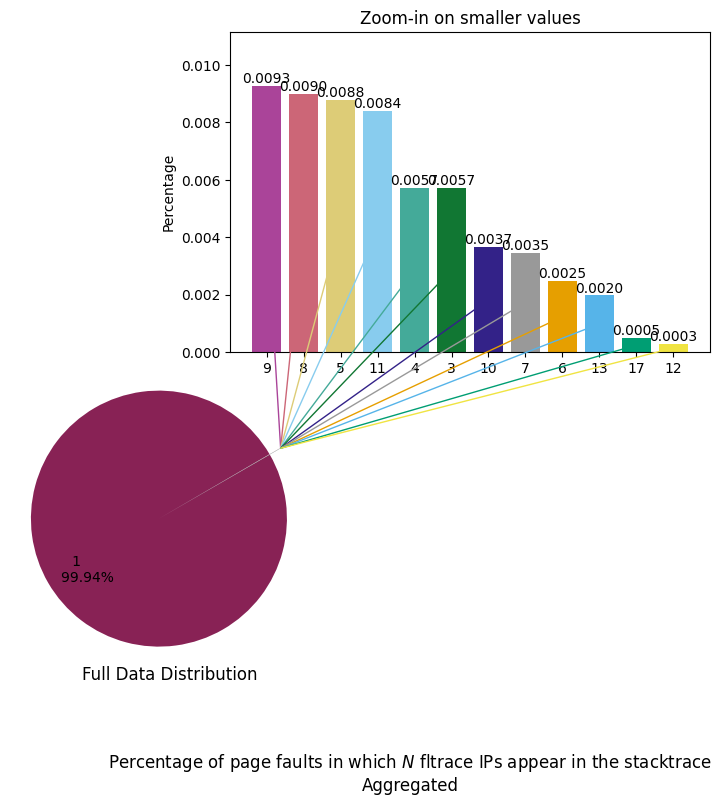

In [12]:
aggregated = pd.concat(all_groups, axis=1, join='outer').fillna(0).sum(axis=1)
aggregated = 100*aggregated/aggregated.sum()
aggregated_fig = plotter.get_pie_bar_zoom_in(aggregated.values,aggregated.index.to_numpy(dtype=str),
                                             fig_title=("Percentage of page faults in which $N$ fltrace IPs appear in the stacktrace"+f"\nAggregated"))
display(aggregated_fig)
plt.close()

It looks like there isn't one data page fault which didn't containt an fltrace IP in its stacktrace!

In [13]:
assert all(len(df[df["number_impacted_ips"] == 0]) == 0 for df in fltrace_impact_stats.values())

Let's look at when on average the first fltrace `ip` appears, grouping by the number of impacted ips

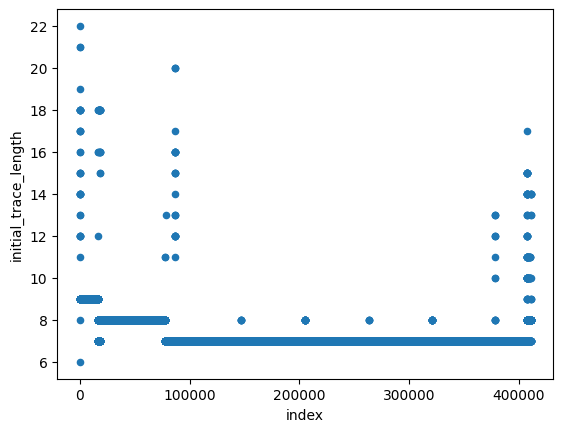

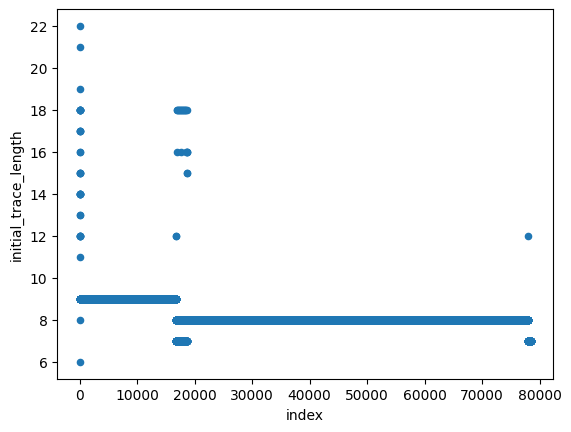

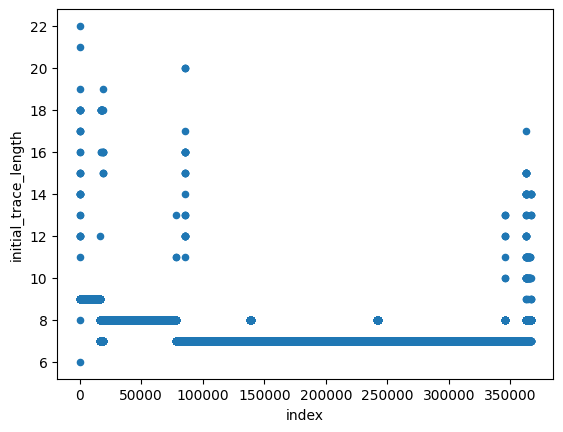

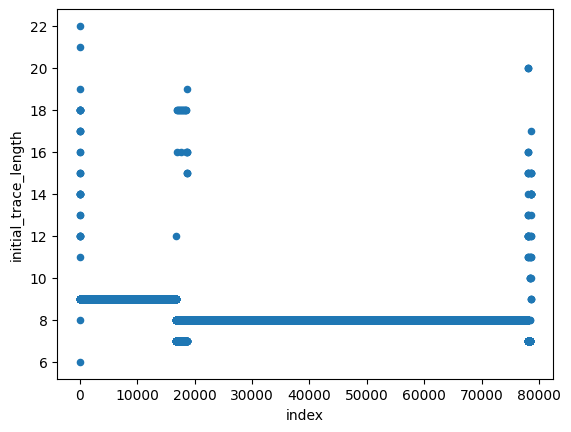

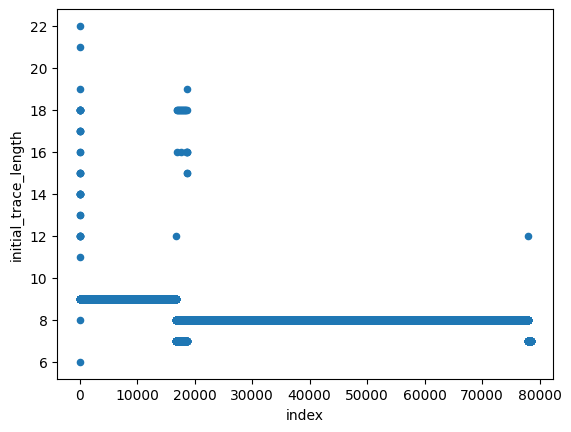

In [14]:
for runid,rs_df in fltrace_impact_stats.items():
    rs_df.reset_index().plot.scatter(x='index',y='initial_trace_length')

Now, let's take a look at the mean position of the ip in the stacktrace.

In [25]:
print("Get stats describing in which position the (faulty) instruction pointer is on average in the stacktrace")
    

for runid,df in all_dfs.items():
    _ ,n_df= get_ip_not_in_st_stats(runid,df)
    all_dfs[runid] = n_df

Get stats describing in which position the (faulty) instruction pointer is on average in the stacktrace
fluidanimate_500_100_30887


Pandas Apply:   0%|          | 0/410448 [00:00<?, ?it/s]

There are 27 ips which don't appear in the stacktrace. 
For example, we have 0x77578bfa0fa0 which is not in its st: 0x77578c2aa93a|0x77578fa7a47e|0x77578fa7a568|0x77578fa942ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/410448 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/410448 [00:00<?, ?it/s]

______________________________
fluidanimate_500_500_72968


Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

There are 8 ips which don't appear in the stacktrace. 
For example, we have 0x734e6f9a0fa0 which is not in its st: 0x734e6fcaa93a|0x734e7354f47e|0x734e7354f568|0x734e735692ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78403 [00:00<?, ?it/s]

______________________________
fluidanimate_500_125_71795


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

There are 27 ips which don't appear in the stacktrace. 
For example, we have 0x7047c0da0fa0 which is not in its st: 0x7047c10aa93a|0x7047c489347e|0x7047c4893568|0x7047c48ad2ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

______________________________
fluidanimate_500_250_72189


Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

There are 21 ips which don't appear in the stacktrace. 
For example, we have 0x7bb8417a0fa0 which is not in its st: 0x7bb841aaa93a|0x7bb8452c947e|0x7bb8452c9568|0x7bb8452e32ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78423 [00:00<?, ?it/s]

______________________________
fluidanimate_500_375_72575


Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

There are 8 ips which don't appear in the stacktrace. 
For example, we have 0x723f7c3a0fa0 which is not in its st: 0x723f7c6aa93a|0x723f7fe3847e|0x723f7fe38568|0x723f7fe522ca.
For the rest, every ip is in the first position of the st.


Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/78404 [00:00<?, ?it/s]

______________________________


# II. Data analysis

Let's start by building the connection DAG, where a vertex is a position in code (instruction pointer) and an edge depicts an IP calling a different IP. That is, all sink vertices are instruction pointers causing a page fault.

In [26]:
from utils.graphs import get_connection_graph, get_sink_source_stats

In [27]:
analysis_run_id,analysis_df = list(all_dfs.items())[2]
print(analysis_run_id)
analysis_df["ip_as_int"] = analysis_df["ip"].swifter.apply(lambda ip_str: int(ip_str,16))

fluidanimate_500_125_71795


Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [28]:
# for runid,df in all_dfs.items():
#     runid: RunIdentifier
#     connection_graph = get_connection_graph(runid,df)
    #assert nx.is_directed_acyclic_graph(connection_graph)
connection_graph = get_connection_graph(analysis_df,extra_info[analysis_run_id])

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/366232 [00:00<?, ?it/s]

In [29]:
connection_graph.number_of_edges()

123

In [30]:
get_sink_source_stats(connection_graph,analysis_df.stacktrace.unique())

There are 5 paths which are never taken by the trace (no stacktrace goes through them). This is because there exist nodes with more than one outgoing edge, which then connect to other nodes with more than one outgoing edge. 
e.g.: n1 -> A -> n2 -> C  ;  yet n1->B->n2->C is never taken, but it is tehcnically a valid path
         |->B -> n2 -> D
There are 56 sinks and 65 stacktraces.


## Adding back the time dimension - per-path grouping 

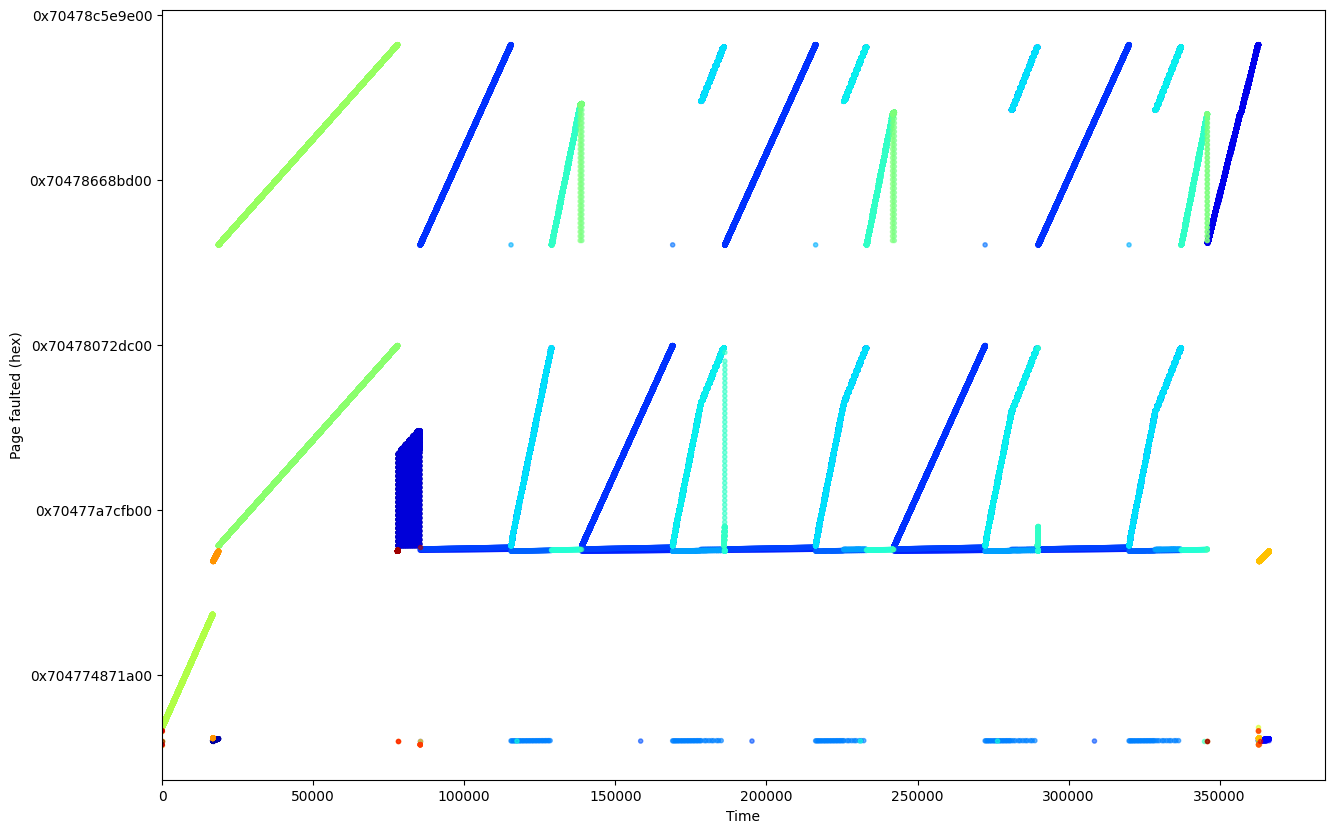

In [35]:

start_point = analysis_df["tstamp"].min()
analysis_df["relative_tstamp"] = analysis_df["tstamp"].apply(lambda t: t-start_point)


grouped_addresses = pd.concat([analysis_df.groupby("stacktrace")["addr"].apply(list).rename("pages").apply(lambda addr_list: [int(addr,16) & ~(PAGE_SIZE-1)  for addr in addr_list]),analysis_df.groupby("stacktrace").size().rename("num_occurrences"),analysis_df.reset_index().groupby("stacktrace")["index"].apply(list).rename("index_occurrences")],axis=1).reset_index()


plt.ioff()
fig,axs = plotter.get_time_graph(grouped_addresses)
plt.ion()
display(fig)

In [36]:
# Exclude the mandatory page faults:
analysis_without_mandatory,_ = get_df_no_cold_miss(analysis_df)
grouped_no_mandatory = get_tl_well_formatted(analysis_without_mandatory)
plt.ioff()
fig,ax = plotter.get_time_graph(grouped_no_mandatory)
plt.ion()
display(fig)


NameError: name 'get_df_no_cold_miss' is not defined

In [146]:
mask_interesting = pd.concat([grouped_no_mandatory,grouped_no_mandatory["stacktrace"].apply(lambda st: st.split('|')[0]).rename("ip")],axis=1)
#mask_interesting["ip"].sort_values()

mask_interesting[mask_interesting["ip"] == "0x7047c0c98ec1"][["pages","index_occurrences"]].apply(lambda row: (row.index_occurrences[:3],','.join([hex(page) for page in row.pages])),axis=1)



40    ([362863, 362881, 362884], 0x704772008000,0x70...
41    ([362841, 362847], 0x704772805000,0x704772807000)
42    ([85433, 85435, 85437], 0x704772008000,0x70477...
dtype: object

In [135]:
grouped_no_mandatory[grouped_no_mandatory["index_occurrences"].apply(lambda lst_indices : sorted(lst_indices)) #.apply(lambda row: (row.index_occurrences[:3],','.join([hex(page) for page in row.pages])),axis=1)


SyntaxError: incomplete input (4007519216.py, line 2)

In [130]:
analysis_df[analysis_df.index.isin([115477,115478,115479])]

,tstamp,ip,addr,flags,regs,stacktrace,ip_as_int,relative_tstamp
115477,1.728159e+09,62e728bded08,704778fe0000,0,140736299714528!123453479405520!0!123451140474...,0x62e728bded08|0x62e728be1a82|0x62e728be1b71|0...,108744960503048,1.372738
115478,1.728159e+09,62e728bded3e,704779300000,0,140736299714528!123453479405520!0!123451140474...,0x62e728bded3e|0x62e728be1a82|0x62e728be1b71|0...,108744960503102,1.372743
115479,1.728159e+09,62e728bdee9c,70477223d000,0,140736299714528!123453479405520!0!123451140474...,0x62e728bdee9c|0x62e728be1a82|0x62e728be1b71|0...,108744960503452,1.372749


In [105]:
def get_group_figure(df,group):
    

plt.ioff()
all_group_figures = []
for 
plt.ion()